# 导入库

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# 数据预处理

## 读取数据

In [2]:
path = '../statistics/trajectory.csv'

In [3]:
dtype = {
    'vehicle_id': np.int16, 
    'datetime':'string', 
    'vehicle_type': np.int8, 
    'velocity': np.float32, 
    'traffic_lane': np.int8, 
    'longitude': np.float32, 
    'latitude': np.float32, 
    'kilopost': np.float32, 
    'vehicle_length': np.float16, 
    'detected_flag': np.int8
}
df = pd.read_csv(path, 
                 names = ['vehicle_id', 'datetime', 'vehicle_type', 'velocity', 'traffic_lane', 'longitude', 'latitude', 'kilopost', 'vehicle_length', 'detected_flag'],
                 dtype = dtype
                )

## 时间

In [4]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%H%M%S%f')

In [5]:
vehicle_id = df['vehicle_id'].unique()
datetime_array = np.array([]).astype(np.float32)
for id in vehicle_id:
    df_id = df[df['vehicle_id'] == id]
    datetime = (df_id['datetime'].values - df_id['datetime'].values[0]).astype(np.timedelta64(1, 'ms')).astype(np.float32) / 1000
    datetime_array = np.append(datetime_array, datetime)

In [6]:
df['datetime'] = datetime_array

In [7]:
df

,vehicle_id,datetime,vehicle_type,velocity,traffic_lane,longitude,latitude,kilopost,vehicle_length,detected_flag
0,0,0.000000,1,57.599998,1,135.459991,34.720890,5056.200195,3.0,1
1,0,0.100000,1,57.400002,1,135.460007,34.720879,5054.200195,3.0,1
2,0,0.200000,1,58.599998,1,135.460007,34.720867,5052.399902,3.0,1
3,0,0.300000,1,59.799999,1,135.460022,34.720852,5050.899902,3.0,1
4,0,0.400000,1,59.200001,1,135.460022,34.720840,5049.299805,3.0,1
...,...,...,...,...,...,...,...,...,...,...
4698918,3756,48.200001,1,50.799999,2,135.473297,34.707199,3009.600098,3.5,1
4698919,3756,48.299999,1,51.000000,2,135.473297,34.707188,3007.800049,3.5,1
4698920,3756,48.400002,1,51.099998,2,135.473312,34.707180,3006.500000,3.5,1
4698921,3756,48.500000,1,51.200001,2,135.473312,34.707169,3005.000000,3.5,1


In [8]:
df['datetime'].value_counts()

0.000000      3031
0.200000      3031
0.300000      3031
0.400000      3031
0.500000      3031
              ... 
253.100006       1
253.000000       1
252.899994       1
252.800003       1
254.199997       1
Name: datetime, Length: 2543, dtype: int64

## 速度

### Savitzky-Golay滤波

In [9]:
from scipy.signal import savgol_filter

In [10]:
# 时间
df0 = df[df['vehicle_id'] == 0]
t0 = df0['datetime'].values
# 速度
v0 = df0['velocity']
# Savizky-Golay
## 参数
window_length = 50
polyorder=3
v0_smooth = savgol_filter(v0, window_length, polyorder)

### 过滤前后对比

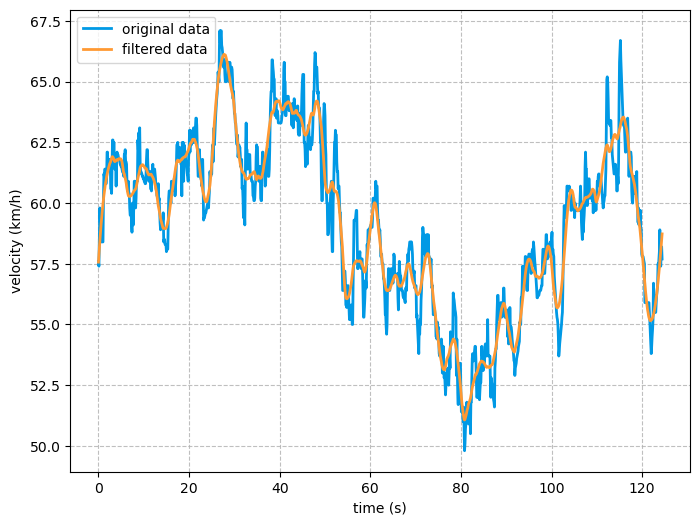

In [11]:
linewidth = 2
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(t0, v0, label='original data', color='#0099e5', linewidth=linewidth)
ax.plot(t0, v0_smooth, label='filtered data', color='#ff9933', linewidth=linewidth)
ax.set_xlabel('time (s)')
ax.set_ylabel('velocity (km/h)')
plt.grid(linestyle='--', alpha=0.8)
plt.legend()

### 将原始速度数据过滤

In [12]:
polyorder=3

In [13]:
df['vehicle_id'].value_counts()

2907    2543
1899    2528
2155    2521
2302    2517
2304    2512
        ... 
3659      82
3680      58
340       56
497       28
3750       7
Name: vehicle_id, Length: 3031, dtype: int64

In [14]:
vehicle_id = df['vehicle_id'].unique()
velocity_array = np.array([])
for id in vehicle_id:
    df_id = df[df['vehicle_id'] == id]
    # 如果速度数据长度不超过120，则不过滤
    if len(df_id) <= 120:
        velocity_array = np.append(velocity_array, df_id['velocity'].values)
    else:
        velocity_array = np.append(velocity_array, savgol_filter(df_id['velocity'].values, 5 * len(df_id) // 120, polyorder))

In [15]:
df['velocity'] = velocity_array

## 加减速度计算

In [16]:
vehicle_id = df['vehicle_id'].unique()
acceleration_array = np.array([])
interval = 0.1
for id in vehicle_id:
    velocity = df[df['vehicle_id'] == id]['velocity'].values
    acceleration = np.append(0, (velocity[1:] - velocity[:-1]) / 0.1)
    acceleration_array = np.append(acceleration_array, acceleration)

In [17]:
a = acceleration_array.copy()
b = acceleration_array.copy()
a[a < 0] = 0
df['acceleration'] = a
b[b > 0] = 0
df['deceleration'] = b

In [18]:
df

,vehicle_id,datetime,vehicle_type,velocity,traffic_lane,longitude,latitude,kilopost,vehicle_length,detected_flag,acceleration,deceleration
0,0,0.000000,1,57.578297,1,135.459991,34.720890,5056.200195,3.0,1,0.000000,0.000000
1,0,0.100000,1,57.874912,1,135.460007,34.720879,5054.200195,3.0,1,2.966156,0.000000
2,0,0.200000,1,58.157948,1,135.460007,34.720867,5052.399902,3.0,1,2.830353,0.000000
3,0,0.300000,1,58.427696,1,135.460022,34.720852,5050.899902,3.0,1,2.697487,0.000000
4,0,0.400000,1,58.684464,1,135.460022,34.720840,5049.299805,3.0,1,2.567673,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
4698918,3756,48.200001,1,51.183971,2,135.473297,34.707199,3009.600098,3.5,1,0.783768,0.000000
4698919,3756,48.299999,1,51.195015,2,135.473297,34.707188,3007.800049,3.5,1,0.110435,0.000000
4698920,3756,48.400002,1,51.128159,2,135.473312,34.707180,3006.500000,3.5,1,0.000000,-0.668564
4698921,3756,48.500000,1,50.972832,2,135.473312,34.707169,3005.000000,3.5,1,0.000000,-1.553268


In [19]:
df1 = df[df['datetime'] == 0]
df1 = df1.sort_values('kilopost')
df1['headway'] = df1['kilopost'] - df1['kilopost'].shift(1)
df1

,vehicle_id,datetime,vehicle_type,velocity,traffic_lane,longitude,latitude,kilopost,vehicle_length,detected_flag,acceleration,deceleration,headway
530811,497,0.0,1,52.900002,1,135.473114,34.707462,3042.300049,3.5,0,0.0,0.0,NaN
4686387,3680,0.0,1,73.199997,2,135.472610,34.707962,3114.199951,3.0,1,0.0,0.0,71.899902
4686197,3660,0.0,1,78.000000,1,135.472382,34.708267,3154.300049,4.5,1,0.0,0.0,40.100098
4686115,3659,0.0,1,90.000000,2,135.472260,34.708355,3170.699951,3.0,1,0.0,0.0,16.399902
4686284,3661,0.0,1,78.000000,1,135.472153,34.708538,3193.800049,4.0,1,0.0,0.0,23.100098
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2889503,2040,0.0,1,5.166356,2,135.459854,34.721046,5077.700195,4.0,1,0.0,0.0,0.000000
3819183,2456,0.0,1,4.259484,2,135.459854,34.721046,5078.000000,4.0,1,0.0,0.0,0.299805
2880336,2036,0.0,1,0.398946,2,135.459854,34.721050,5078.200195,4.0,1,0.0,0.0,0.200195
3508668,2314,0.0,1,1.839226,2,135.459854,34.721050,5078.200195,4.5,1,0.0,0.0,0.000000


## 跟车时距和间距

In [20]:
def headway(df, l):
    d_list = []
    df_grouped = df[df['traffic_lane'] == 1].groupby('datetime')
    for t, d in tqdm(df_grouped):
        d = d.sort_values('kilopost')
        d['headway'] = d['kilopost'] - d['kilopost'].shift(1)
        d_list.append(d)
    df_l = pd.concat(d_list)
    return df_l

#### 计算跟车间距

In [21]:
df1, df2 = headway(df, 1), headway(df, 2)
df = pd.concat([df1, df2])

100%|████████████████████████████████████████████████████████████████████████████| 2543/2543 [00:01<00:00, 2295.32it/s]


#### 异常值处理

##### 去除空值

In [22]:
df.dropna(inplace=True)

##### 去除跟车间距小于等于0的数据

In [23]:
df = df[(df['headway'] > 0)]
df

,vehicle_id,datetime,vehicle_type,velocity,traffic_lane,longitude,latitude,kilopost,vehicle_length,detected_flag,acceleration,deceleration,headway
4686197,3660,0.000000,1,78.000000,1,135.472382,34.708267,3154.300049,4.5,1,0.000000,0.0,112.000000
4686284,3661,0.000000,1,78.000000,1,135.472153,34.708538,3193.800049,4.0,1,0.000000,0.0,39.500000
4685884,3638,0.000000,1,64.668571,1,135.472076,34.708611,3204.000000,4.5,1,0.000000,0.0,10.199951
4680578,3572,0.000000,1,89.933334,1,135.470245,34.710701,3491.600098,3.5,1,0.000000,0.0,287.600098
4679964,3558,0.000000,1,61.934433,1,135.469803,34.711220,3567.800049,3.5,1,0.000000,0.0,76.199951
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4468108,2907,252.300003,1,46.791313,1,135.473175,34.707367,3030.800049,5.0,1,1.245193,0.0,20.600098
4468109,2907,252.399994,1,46.925320,1,135.473190,34.707355,3029.399902,5.0,1,1.340065,0.0,20.500000
4468110,2907,252.500000,1,47.069004,1,135.473206,34.707344,3027.800049,5.0,1,1.436844,0.0,20.600098
4468111,2907,252.600006,1,47.222569,1,135.473206,34.707333,3026.199951,5.0,1,1.535645,0.0,20.300049


#### 计算跟车时距

In [24]:
df['time_headway'] = df['headway'] / df['velocity'] * 3.6
df = df[df['time_headway'] <= 4]
df

,vehicle_id,datetime,vehicle_type,velocity,traffic_lane,longitude,latitude,kilopost,vehicle_length,detected_flag,acceleration,deceleration,headway,time_headway
4686284,3661,0.000000,1,78.000000,1,135.472153,34.708538,3193.800049,4.0,1,0.000000,0.0,39.500000,1.823077
4685884,3638,0.000000,1,64.668571,1,135.472076,34.708611,3204.000000,4.5,1,0.000000,0.0,10.199951,0.567816
4680260,3559,0.000000,1,77.825279,1,135.469559,34.711494,3604.899902,4.5,1,0.000000,0.0,37.099854,1.716145
4678706,3548,0.000000,1,64.778152,1,135.469299,34.711792,3645.300049,4.0,1,0.000000,0.0,40.400146,2.245210
4698436,3756,0.000000,1,44.285175,1,135.469101,34.712036,3676.899902,3.5,1,0.000000,0.0,31.599854,2.568794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4468108,2907,252.300003,1,46.791313,1,135.473175,34.707367,3030.800049,5.0,1,1.245193,0.0,20.600098,1.584917
4468109,2907,252.399994,1,46.925320,1,135.473190,34.707355,3029.399902,5.0,1,1.340065,0.0,20.500000,1.572712
4468110,2907,252.500000,1,47.069004,1,135.473206,34.707344,3027.800049,5.0,1,1.436844,0.0,20.600098,1.575567
4468111,2907,252.600006,1,47.222569,1,135.473206,34.707333,3026.199951,5.0,1,1.535645,0.0,20.300049,1.547569


## 异常值再处理

### 去除加速度大于0.6g

In [70]:
df = df[df['acceleration'] < 0.6 * 9.8]

### 去除减速度大于 -8

In [72]:
df = df[df['deceleration'] > -8]

### 去除数据量过小的值

In [97]:
th = 100
df = df.groupby('vehicle_id').filter(lambda x: len(x) > 100)

### 重置index

In [328]:
df.reset_index(drop=True)

,vehicle_id,datetime,vehicle_type,velocity,traffic_lane,longitude,latitude,kilopost,vehicle_length,detected_flag,acceleration,deceleration,headway,time_headway,driving_style
0,3661,0.000000,1,78.000000,1,135.472153,34.708538,3193.800049,4.0,1,0.000000,0.0,39.500000,1.823077,2
1,3638,0.000000,1,64.668571,1,135.472076,34.708611,3204.000000,4.5,1,0.000000,0.0,10.199951,0.567816,2
2,3559,0.000000,1,77.825279,1,135.469559,34.711494,3604.899902,4.5,1,0.000000,0.0,37.099854,1.716145,2
3,3548,0.000000,1,64.778152,1,135.469299,34.711792,3645.300049,4.0,1,0.000000,0.0,40.400146,2.245210,2
4,3756,0.000000,1,44.285175,1,135.469101,34.712036,3676.899902,3.5,1,0.000000,0.0,31.599854,2.568794,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3330761,2907,252.300003,1,46.791313,1,135.473175,34.707367,3030.800049,5.0,1,1.245193,0.0,20.600098,1.584917,4
3330762,2907,252.399994,1,46.925320,1,135.473190,34.707355,3029.399902,5.0,1,1.340065,0.0,20.500000,1.572712,4
3330763,2907,252.500000,1,47.069004,1,135.473206,34.707344,3027.800049,5.0,1,1.436844,0.0,20.600098,1.575567,4
3330764,2907,252.600006,1,47.222569,1,135.473206,34.707333,3026.199951,5.0,1,1.535645,0.0,20.300049,1.547569,4


### 排序

In [331]:
df = df.sort_values(by=['vehicle_id', 'datetime'])
df

,vehicle_id,datetime,vehicle_type,velocity,traffic_lane,longitude,latitude,kilopost,vehicle_length,detected_flag,acceleration,deceleration,headway,time_headway,driving_style
0,0,0.000000,1,57.578297,1,135.459991,34.720890,5056.200195,3.0,1,0.000000,0.0,1.200195,0.075040,1
0,0,0.000000,1,57.578297,1,135.459991,34.720890,5056.200195,3.0,1,0.000000,0.0,1.200195,0.075040,1
1,0,0.100000,1,57.874912,1,135.460007,34.720879,5054.200195,3.0,1,2.966156,0.0,1.000000,0.062203,1
1,0,0.100000,1,57.874912,1,135.460007,34.720879,5054.200195,3.0,1,2.966156,0.0,1.000000,0.062203,1
2,0,0.200000,1,58.157948,1,135.460007,34.720867,5052.399902,3.0,1,2.830353,0.0,1.199707,0.074262,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4698676,3756,24.000000,1,50.236477,1,135.470963,34.709850,3377.000000,3.5,0,3.137856,0.0,42.699951,3.059924,2
4698677,3756,24.100000,1,50.570267,1,135.470978,34.709831,3374.899902,3.5,0,3.337898,0.0,42.299805,3.011242,2
4698677,3756,24.100000,1,50.570267,1,135.470978,34.709831,3374.899902,3.5,0,3.337898,0.0,42.299805,3.011242,2
4698678,3756,24.200001,1,50.849129,1,135.470993,34.709816,3373.800049,3.5,0,2.788620,0.0,42.900146,3.037231,2


## 保存数据

In [332]:
df.to_csv('../statistics/data_reprocessed.csv', index=False)

## 驾驶行为波动性

In [74]:
def tvsv(x):
    r = np.log(x[1:] / x[:-1])
    return np.std(r)

In [153]:
dt = {'vehicle_id' : [],
      'velocity_std' : [], 
      'acceleration_std' : [],
      'deceleration_std' : [],
      'acceleration_max' : [],
      'deceleration_min' : [],
      'velocity_mad' : [], 
      'acceleration_mad' : [],
      'deceleration_mad' : [],
      'velocity_cv' : [],
      'velocity_tvsv' : [],
      'velocity_max' : [],
      'velocity_min' : [],
      'time_headway_mean' : []
     }

In [154]:
vehicle_id = df['vehicle_id'].unique()
velocity_array = np.array([])
for id in vehicle_id:
    dt['vehicle_id'].append(id)
    df_id = df[df['vehicle_id'] == id]
    # 速度、加速度、减速度
    velocity = df_id['velocity'].values
    acceleration = df_id['acceleration'].values
    acceleration = acceleration[np.where(acceleration >= 0)]
    deceleration = df_id['deceleration'].values
    deceleration = deceleration[np.where(deceleration <= 0)]
    # 最值 
    dt['velocity_max'].append(np.max(velocity))
    dt['velocity_min'].append(np.min(velocity))
    dt['acceleration_max'].append(np.max(acceleration))
    dt['deceleration_min'].append(np.min(deceleration))
    # 均值
    velocity_mean = np.mean(velocity)
    acceleration_mean = np.mean(acceleration)
    deceleration_mean = np.mean(deceleration)
    dt['time_headway_mean'].append(np.mean(df_id['time_headway'].values))
    # 标准差
    velocity_std = np.std(velocity)
    acceleration_std = np.std(acceleration)
    deceleration_std = np.std(deceleration)
    dt['velocity_std'].append(velocity_std)
    dt['acceleration_std'].append(acceleration_std)
    dt['deceleration_std'].append(deceleration_std)
    if np.isnan(deceleration_std):
        print(id)
    # 平均绝对偏差
    dt['velocity_mad'].append(np.mean(np.abs(velocity - velocity_mean)))
    dt['acceleration_mad'].append(np.mean(np.abs(acceleration - acceleration_mean)))
    dt['deceleration_mad'].append(np.mean(np.abs(deceleration - deceleration_mean)))
    # 变异系数
    dt['velocity_cv'].append(velocity_std / np.abs(velocity_mean))
    # 时变随机波动性
    dt['velocity_tvsv'].append(tvsv(velocity))

In [155]:
for key, value in dt.items():
    dt[key] = np.array(value)

## 标准化

实际上不需要标准化或者归一化,参考https://zhuanlan.zhihu.com/p/660472413

## 将特征数据转化为矩阵

In [284]:
features = np.array([list(value) for value in dt.values()])
features = features.T

In [285]:
features.shape

(1556, 15)

In [286]:
features

array([[3.66100000e+03, 3.96041713e+00, 1.01379153e+00, ...,
        6.51999969e+01, 1.85000709e+00, 3.00000000e+00],
       [3.63800000e+03, 4.38110189e+00, 1.36153034e+00, ...,
        4.99542847e+01, 1.65021811e+00, 3.00000000e+00],
       [3.55900000e+03, 1.68949844e+00, 1.11903138e+00, ...,
        6.81405640e+01, 1.92019902e+00, 3.00000000e+00],
       ...,
       [1.95200000e+03, 1.68960793e+00, 1.36730918e-01, ...,
        4.66479759e+01, 9.84269469e-02, 5.00000000e+00],
       [1.89000000e+03, 2.69391198e+00, 4.68561553e-01, ...,
        4.52516251e+01, 1.80236650e-01, 5.00000000e+00],
       [1.98600000e+03, 3.40570034e+00, 4.83071996e-01, ...,
        4.20295258e+01, 1.65443298e-01, 5.00000000e+00]])

# 驾驶行为分类

## 层次聚类 (Hierarchical Clustering)

参考：https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering

In [287]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

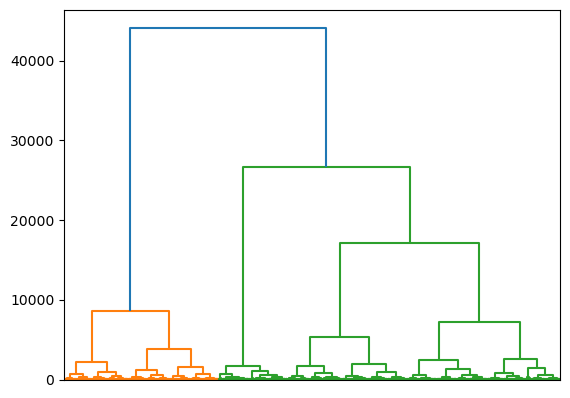

In [304]:
linkage_data = linkage(features, method='ward', metric='euclidean')
p = dendrogram(linkage_data, no_labels=True)
plt.savefig('../pictures/hierarchical_clustering.png')
cluster = fcluster(Z=linkage_data, t=10000, criterion='distance')

In [305]:
np.unique(cluster)

array([1, 2, 3, 4], dtype=int32)

In [306]:
dt['cluster'] = cluster 

In [307]:
df_classification = pd.DataFrame(dt)
df_classification.to_excel('../statistics/driving_behavior_classification.xlsx')

In [308]:
df_classification

,vehicle_id,velocity_std,acceleration_std,deceleration_std,acceleration_max,deceleration_min,velocity_mad,acceleration_mad,deceleration_mad,velocity_cv,velocity_tvsv,velocity_max,velocity_min,time_headway_mean,cluster
0,3661,3.960417,1.013792,1.615892,5.000000,-5.999985,3.571952,0.583332,1.277778,0.056788,0.017702,78.199997,65.199997,1.850007,2
1,3638,4.381102,1.361530,2.185723,5.828590,-7.485733,4.092607,0.979644,1.876053,0.077189,0.018304,64.668571,49.954285,1.650218,2
2,3559,1.689498,1.119031,1.455660,5.594406,-7.461548,1.077075,0.827671,1.093077,0.024109,0.005346,78.227570,68.140564,1.920199,2
3,3548,2.846166,1.540947,1.612666,5.874481,-7.774506,2.418228,1.224421,1.261690,0.040514,0.005419,74.874107,64.758926,2.040981,2
4,3756,2.381991,1.135216,1.092386,5.841637,-3.674240,1.824629,0.915980,0.888847,0.054635,0.008924,50.849129,39.246441,1.851995,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,2871,0.945818,0.338485,0.316754,0.808868,-1.080132,0.835715,0.321877,0.252191,0.018366,0.003205,53.104183,50.354023,0.101364,4
1552,2606,6.034883,0.028978,0.983813,0.186920,-3.192101,5.435800,0.015852,0.877596,0.121360,0.022397,59.832561,41.810879,0.103023,4
1553,1952,1.689608,0.136731,0.311394,0.538406,-1.203613,1.463411,0.109159,0.272522,0.034159,0.004280,51.523708,46.647976,0.098427,4
1554,1890,2.693912,0.468562,0.508769,1.401825,-1.772156,2.265116,0.425409,0.450892,0.054149,0.004204,56.111774,45.251625,0.180237,4


In [309]:
vehicle_ids = dt['vehicle_id']
for i in tqdm(range(len(vehicle_ids))):
    id = dt['vehicle_id'][i]
    df.loc[df['vehicle_id'] == id, 'driving_style'] = dt['cluster'][i]

100%|█████████████████████████████████████████████████████████████████████████████| 1556/1556 [00:02<00:00, 570.56it/s]


## 聚类结果分析

In [311]:
clusters = np.unique(df_classification['cluster'].values)
dt_comparison = {}
for cluster in clusters:
    df_cluster = df_classification[df_classification['cluster'] == cluster]
    dt_comparison[str(cluster)] = [
        df_cluster['velocity_max'].mean(),
        df_cluster['velocity_min'].mean(),
        df_cluster['velocity_std'].mean(),
        df_cluster['velocity_mad'].mean(),
        df_cluster['velocity_tvsv'].mean(),
        df_cluster['acceleration_mad'].mean(),
        df_cluster['acceleration_max'].mean(),
        df_cluster['acceleration_std'].mean(),
        df_cluster['deceleration_mad'].mean(),
        df_cluster['deceleration_min'].mean(),
        df_cluster['deceleration_std'].mean(),
        df_cluster['time_headway_mean'].max(),
        df_cluster['time_headway_mean'].min(),
        df_cluster['time_headway_mean'].mean(),
        ]

In [312]:
df_comparison = pd.DataFrame(
    dt_comparison, 
    index=[
        'velocity_max', 
        'velocity_min', 
        'velocity_std', 
        'velocity_mad', 
        'velocity_tvsv', 
        'acceleration_mad', 
        'acceleration_max', 
        'acceleration_std',
        'deceleration_mad',
        'deceleration_min',
        'deceleration_std',
        'time_headway_mean_max',
        'time_headway_mean_min',
        'time_headway_mean'
    ]
)
df_comparison

,1,2,3,4
velocity_max,73.769474,62.686531,64.541392,53.921363
velocity_min,52.219822,38.086069,22.595636,12.274372
velocity_std,5.264689,6.244346,10.525357,10.701478
velocity_mad,4.380141,5.172870,8.703671,8.977133
velocity_tvsv,0.006010,0.013479,0.009509,0.012718
acceleration_mad,0.575858,0.896563,0.603778,0.584050
acceleration_max,3.487122,4.860833,3.710348,3.531161
acceleration_std,0.728328,1.113953,0.762224,0.726617
deceleration_mad,0.633370,0.758746,0.668915,0.615936
deceleration_min,-4.184892,-5.084187,-4.644385,-4.481296


# 数据驱动跟驰模型

## 数据准备

In [399]:
driving_style = np.sort(df['driving_style'].unique())
dt_features = {}
dt_target = {}
for i, style in enumerate(driving_style):
    df_style = df[df['driving_style'] == style]
    values = df_style[['velocity', 'time_headway', 'acceleration', 'deceleration']].values
    dt_features[str(style)] = values[:,:2]
    dt_target[str(style)] = np.sum(values[:,2:], axis=1)

In [400]:
dt_features

{'1': array([[57.57829666,  0.07504048],
        [57.57829666,  0.07504048],
        [57.87491226,  0.06220312],
        ...,
        [44.02641678,  0.179888  ],
        [43.89247131,  0.19685671],
        [43.89247131,  0.19685671]]),
 '2': array([[86.99901581,  3.86900929],
        [86.99901581,  3.86900929],
        [87.47317505,  3.83569823],
        ...,
        [50.57026672,  3.01124172],
        [50.84912872,  3.03723055],
        [50.84912872,  3.03723055]]),
 '3': array([[6.14864159e+01, 5.86066951e-03],
        [6.14864159e+01, 5.86066951e-03],
        [6.16878624e+01, 5.84153103e-03],
        ...,
        [3.79700241e+01, 8.53443583e-02],
        [3.79901695e+01, 1.89707794e-02],
        [3.79901695e+01, 1.89707794e-02]]),
 '4': array([[4.84596062e+01, 2.23083672e-02],
        [4.84596062e+01, 2.23083672e-02],
        [4.79618759e+01, 7.51329166e-03],
        ...,
        [7.50596924e+01, 3.64514571e-01],
        [7.51985703e+01, 3.49477067e-01],
        [7.51985703e+01, 3.4

In [401]:
dt_target

{'1': array([ 0.        ,  0.        ,  2.96615601, ..., -1.4377594 ,
        -1.33945465, -1.33945465]),
 '2': array([0.        , 0.        , 4.74159241, ..., 3.33789825, 2.78862   ,
        2.78862   ]),
 '3': array([0.87284088, 0.87284088, 1.04915619, ..., 0.09212494, 0.20145416,
        0.20145416]),
 '4': array([-0.81516266, -0.81516266, -1.10771179, ...,  1.2071228 ,
         1.38877869,  1.38877869])}

## 随机森林

In [408]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

### style 1

In [406]:
s = '1'
feature_train, feature_test, target_train, target_test = train_test_split(dt_features[s], dt_target[s], test_size=0.2, random_state=0)
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
regressor.fit(feature_train, target_train)
target_pred = regressor.predict(feature_test)

In [409]:
print('Mean Absolute Error:', metrics.mean_absolute_error(target_test, target_pred))
print('Mean Squared Error:', metrics.mean_squared_error(target_test, target_pred))
print('Root Mean Squared Error:',
      np.sqrt(metrics.mean_squared_error(target_test, target_pred)))

Mean Absolute Error: 0.62877216802542
Mean Squared Error: 0.8233727992433804
Root Mean Squared Error: 0.9073989195736241
